In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

from astropy.io import fits
import os, sys

import photutils

import astropy.units as u

from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord

import urllib

from SPCA import Photometry_Aperture

In [200]:
ch = 2
oversamp = True
oversampTimes = 10
method = 'exact'

# # WASP-103b
# aperad = 2.6
# dx = 0.13218
# dy = 0.15009
# tinytim_path = '/home/taylor/Downloads/stinytimv2.0/stinytim/WASP103.fits'

# WASP-12b
aperad = 2.2 # Old
# aperad = 3.2 # New
dx = 0.31836
dy = 0.831538
tinytim_path = '/home/taylor/Downloads/stinytimv2.0/stinytim/WASP12.fits'

# # CoRoT-2b
# aperad = 3.6
# dx = 1.625
# dy = 2.9933
# tinytim_path = '/home/taylor/Downloads/stinytimv2.0/stinytim/CoRoT2.fits'

if oversamp:
    aperad *= oversampTimes

In [201]:
file = fits.open(tinytim_path)
data = file[0].data
data = data[np.newaxis,:]
header = file[0].header
file.close()

In [202]:
if oversamp:
    dx *= oversampTimes
    dy *= oversampTimes

cx_empirical = np.mean(np.arange(data[0].shape[0])*np.sum(data[0], axis=1)/np.mean(np.sum(data[0], axis=1)))
cy_empirical = np.mean(np.arange(data[0].shape[1])*np.sum(data[0], axis=0)/np.mean(np.sum(data[0], axis=0)))

cx = (cx_empirical-dx)
cy = (cy_empirical-dy)

print(cx_empirical/oversampTimes, cy_empirical/oversampTimes)
print(cx/oversampTimes, cy/oversampTimes)

187.44419918062755 187.64919235360014
187.12583918062757 186.81765435360015


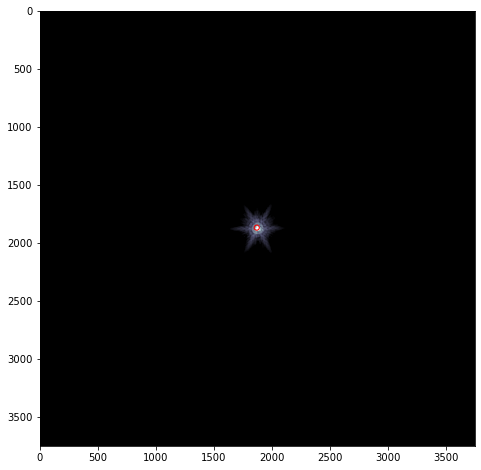

In [203]:
plt.figure(figsize=(8,8))
plt.imshow(data[0], cmap='bone', norm=colors.LogNorm(vmin=data[0].max()/50000, vmax=data[0].max()/10))
c = plt.Circle((cx, cy), aperad, ec='red', fc='None')
plt.gca().add_artist(c)
plt.show()

In [204]:
flux = Photometry_Aperture.A_photometry([0], cx=cx, cy=cy, r=[aperad], methods=[method], img_data=data)
contam = flux[0]/np.sum(data)
print(contam)

0.7826989890559137


### WASP-12b

In [205]:
R_comp = 0.56 # Stevenson+2014a
Teff_comp = 3660
logg_comp = 5.0 # median value from https://arxiv.org/pdf/1810.13252.pdf
feh_comp = 0 # median value from https://arxiv.org/pdf/1810.13252.pdf
N_comp = 2

R_host = 1.657
Teff_host = 6360
logg_host = 4.17
feh_host = 0.30

### WASP-103b

In [179]:
R_comp = 0.665 # https://en.wikipedia.org/wiki/61_Cygni
Teff_comp = 4400
logg_comp = 4.40 # https://en.wikipedia.org/wiki/61_Cygni
feh_comp = -0.20 # https://en.wikipedia.org/wiki/61_Cygni
N_comp = 1

R_host = 1.436
Teff_host = 6110
logg_host = 4.22
feh_host = 0.06

### CoRoT-2b

In [191]:
R_comp = 0.65 # https://en.wikipedia.org/wiki/HD_113538
Teff_comp = 4000
logg_comp = 4.28 # median value from https://arxiv.org/pdf/1810.13252.pdf
feh_comp = -0.17 # median value from https://arxiv.org/pdf/1810.13252.pdf
N_comp = 1

R_host = 0.902
Teff_host = 5620
logg_host = 4.66
feh_host = -0.03

In [206]:
phoenixPath = '/home/taylor/Documents/Research/PHOENIX/HiResFITS/'
phoenixWavFile = '/home/taylor/Documents/Research/PHOENIX/HiResFITS/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'

with fits.open(phoenixWavFile) as f:
    wavStar = f[0].data*1e-4 # angstrom to micron

In [207]:
fStars = []

for Rstar, teff, logg, feh, Nstar in [[R_host, Teff_host, logg_host, feh_host, 1], [R_comp, Teff_comp, logg_comp, feh_comp, N_comp]]:

    # Get the phoenix file ready to compute the stellar brightness temperature
    teffStr = teff
    if teffStr <= 7000:
        teffStr = teffStr - (teffStr%100) + np.rint((teffStr%100)/100)*100
    elif teffStr > 7000:
        teffStr = teffStr - (teffStr%200) + np.rint((teffStr%200)/200)*200
    elif teffStr > 12000:
        teffStr = 12000
    teffStr = str(int(teffStr)).zfill(5)

    if np.isnan(logg):
        logg = 4.5
    logg = logg - (logg%0.5) + np.rint((logg%0.5)*2)/2.
    logg = -logg
    
    if np.isnan(feh):
        feh = 0.
    feh = (feh - (feh%0.5) + np.rint((feh%0.5)*2)/2.)
    if feh<-2.:
        feh = (feh - (feh%1) + np.rint((feh%1)))
        
    webfile = ('lte'+teffStr
           +("{0:+.02f}".format(logg) if logg!=0 else '-0.00')
           +("{0:+.01f}".format(feh) if feh!=0 else '-0.0')
           +'.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
    
    webfolder = 'ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/'
    webfolder += 'PHOENIX-ACES-AGSS-COND-2011/Z'+("{0:+.01f}".format(feh) if feh!=0 else '-0.0')+'/'
    
    phoenixSpectraFile = phoenixPath+webfile
    
    if not os.path.exists(phoenixSpectraFile):
        print('Downloading relevant PHOENIX spectra...', flush=True)
        try:
            _ = urllib.request.urlretrieve(webfolder+webfile, phoenixSpectraFile)
        except:
            # Fix: throw a proper error
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.',
                  flush=True)
            break
        print('Done download.', flush=True)
    
    with fits.open(phoenixSpectraFile) as f:
        fStars.append(f[0].data*1e-1*Rstar**2*Nstar) # 'erg/s/cm^2/cm' to kg/s^3

In [208]:
with open('SpitzerResponseCurves/Spitzer_Ch2_ResponseCurve_Subarray.txt', 'r') as f:
# with open('SpitzerResponseCurves/Spitzer_Ch2_ResponseCurve_FullFrame.txt', 'r') as f:
    f.readline()
    f.readline()
    f.readline()
    lines = f.readlines()

lines = np.array([line.strip().split('\t') for line in lines]).astype(float)

In [209]:
fluxes = []

wavTemp = wavStar[np.logical_and(wavStar>=lines[0][0], wavStar<=lines[-1][0])]
for f in fStars:
    fTemp = f[np.logical_and(wavStar>=lines[0][0], wavStar<=lines[-1][0])]
    fTemp *= lines[[np.argmin(np.abs(lines[:,0]-wavTemp[i])) for i in range(len(wavTemp))],1]
    
    fluxes.append(fTemp)

In [210]:
alpha_comp = np.mean(fluxes[1]/fluxes[0])

In [211]:
print(contam)
print(alpha_comp)
print(contam*alpha_comp)

0.7826989890559137
0.11607887
0.09085481303223122
